
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [328]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

% matplotlib inline

def create_undist_coeff():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    calib_img = None
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)     
        if calib_img is None:
            calib_img = gray

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
                   
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, calib_img.shape[::-1], None, None)
    return mtx, dist

mtx, dist = create_undist_coeff()

In [329]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

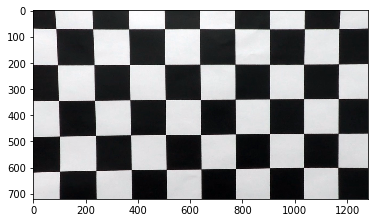

In [335]:
image_name = 'camera_cal/calibration1.jpg'
image = undistort(cv2.imread(image_name), mtx, dist)
cv2.imwrite("output/calib0.jpg", image)
plt.imshow(image)

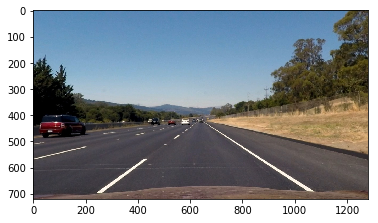

In [336]:
image_name = 'test_images/test0.jpg'
image = undistort(cv2.imread(image_name), mtx, dist)
cv2.imwrite("output/test0.jpg", image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [275]:
def normalize(array):
    return np.uint8(255 * array / np.max(array))

def apply_threshold(src, mask, threshold):
    mask[(src >= threshold[0]) & (src <= threshold[1])] = 1
    return mask

def threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=9)
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    direction = np.arctan2(sobel_y, sobel_x)
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)
    
    white = cv2.inRange(hls, (0, 230, 0), (255, 255, 255))
    yellow = cv2.inRange(hls, (0, 150, 150), (50, 255, 255))
    color_mask = cv2.bitwise_or(white, yellow)
    
    sobel_x_threshold = (40, 250)
    sobel_x = normalize(sobel_x)
    sobel_x_mask = apply_threshold(sobel_x, np.zeros_like(gray), sobel_x_threshold)
    
    sobel_y_threshold = (40, 250)
    sobel_y = normalize(sobel_y)
    sobel_y_mask = apply_threshold(sobel_y, np.zeros_like(gray), sobel_y_threshold)
    
    magnitude_threshold = (40, 100)
    magnitude = normalize(magnitude)
    magnitude_mask = apply_threshold(magnitude, np.zeros_like(gray), magnitude_threshold)
    
    direction_threshold = (0.7, 1.3)
    direction_mask = apply_threshold(direction, np.zeros_like(gray), direction_threshold)

    result = np.zeros_like(gray)
    result[(color_mask == 255) | (sobel_x_mask == 1) & (sobel_y_mask == 1) | (direction_mask == 1) & (magnitude_mask == 1)] = 1

    return result

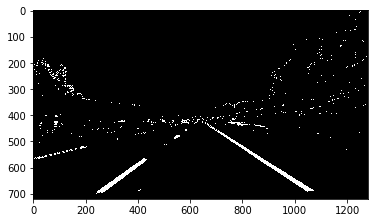

In [344]:
image_name = 'test_images/test0.jpg'
image = threshold(undistort(cv2.imread(image_name), mtx, dist))
cv2.imwrite("output/threshold.jpg", image * 255)
plt.imshow(image, cmap="gray")

In [345]:
def get_warp_dims(img, unwarp=False):
    shape = img.shape
    w = shape[1]
    h = shape[0]
    src = np.float32([[200, h], [w // 2 - 30, h // 2 + 77], [w // 2 + 30, h // 2 + 77], [w - 150, h]])
    dst = np.float32([[300, h], [300, 0], [w - 300, 0], [w - 300, h]])
    
    if not unwarp:
        return (src, dst)
    else:
        return (dst, src)

def warp(img, unwarp=False):
    src, dst = get_warp_dims(img, unwarp=unwarp)
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

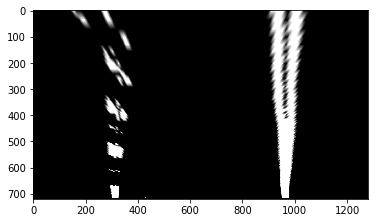

In [346]:
image_name = 'test_images/test0.jpg'
image = warp(threshold(undistort(cv2.imread(image_name), mtx, dist)))
cv2.imwrite("output/warped.jpg", image * 255)
plt.imshow(image, cmap="gray")

In [352]:
from scipy.interpolate import interp1d

def fit_lines(src):
    histogram = np.sum(src[src.shape[0] // 2:,:], axis=0)
    out_img = np.array(cv2.merge((src, src, src)), dtype=np.uint8) * 255
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 15
    window_height = np.int(((src.shape[0]) // nwindows))
    nonzero = src.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = src.shape[0] - (window + 1) * window_height
        win_y_high = src.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    y = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left = (left_fit[0] * y ** 2 + left_fit[1] * y + left_fit[2])
    right = (right_fit[0] * y ** 2 + right_fit[1] * y + right_fit[2])
    
    out = cv2.merge((src, src, src)).astype(np.uint8) * 255
    out[lefty, leftx] = (255, 0, 0)
    out[righty, rightx] = (0, 0, 255)
    
    pts_left = np.array([np.stack([left, y], axis=1)]).astype(int)
    pts_right = np.array([np.flipud(np.stack([right, y], axis=1))]).astype(int)
    
    lines = np.zeros_like(out)
    cv2.polylines(lines, pts_left, False, (0, 255, 0), 10)
    cv2.polylines(lines, pts_right, False, (0, 255, 0), 10)
    
    out = cv2.addWeighted(out, 1, lines, .4, 0.)
    
    return left_fit, right_fit, out

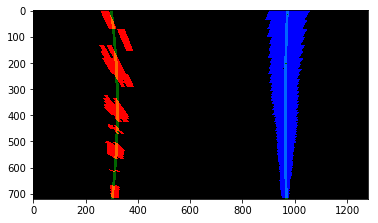

In [353]:
image_name = 'test_images/test0.jpg'
_, _, image = fit_lines(warp(threshold(undistort(cv2.imread(image_name), mtx, dist))))
cv2.imwrite("output/fit.jpg", image)
plt.imshow(image)

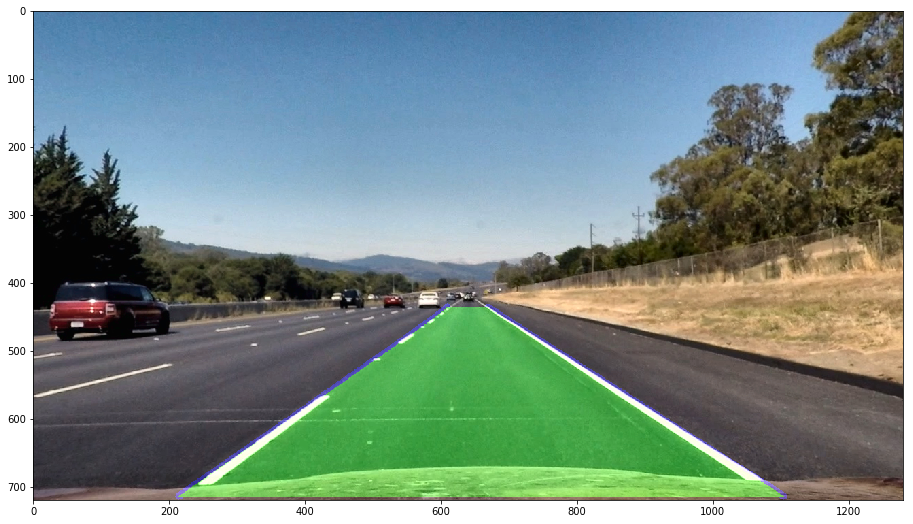

In [358]:
test_images = glob.glob('test_images/test0.jpg')
figure = plt.figure()
f, plots = plt.subplots(1, 1, figsize=(24, 9))
plots = np.reshape(plots, [-1])

for i, name in enumerate(test_images):
    img = undistort(cv2.imread(name), mtx, dist)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_image[:, :, 0] = clahe.apply(lab_image[:, :, 0])
    img = cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    thresholded = threshold(img)
    warped = warp(thresholded)
    
    left_fit, right_fit, _ = fit_lines(warped)
    y = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left = (left_fit[0] * y ** 2 + left_fit[1] * y + left_fit[2])
    right = (right_fit[0] * y ** 2 + right_fit[1] * y + right_fit[2])
    
    pts_left = np.array([np.stack([left, y], axis=1)])
    pts_right = np.array([np.flipud(np.stack([right, y], axis=1))])
    
    
    src, dst = get_warp_dims(img, unwarp=True)
    Minv = cv2.getPerspectiveTransform(src, dst)
    pts_left = cv2.perspectiveTransform(pts_left, Minv).astype(int)
    pts_right = cv2.perspectiveTransform(pts_right, Minv).astype(int)
    
    lines = np.zeros_like(img)
    cv2.polylines(lines, pts_left, False, (255, 0, 0), 10)
    cv2.polylines(lines, pts_right, False, (255, 0, 0), 10)
    cv2.fillPoly(lines, np.hstack([pts_left, pts_right]), (0, 255, 0))
          
    img = cv2.addWeighted(img, 1, lines, .4, 0.)
    
    cv2.imwrite("output/lane.jpg", img)

    plots[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')